In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [46]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
torch.manual_seed(180401042)

In [48]:
# CustomDataset sınıfını tanımlayın
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.df.iloc[idx, :-1].values
        y = self.df.iloc[idx, -1]

        if self.transform:
            X = self.transform(X)

        return X, y

In [49]:
class ToTensor1D(object):
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


train_dataset = CustomDataset('/content/drive/MyDrive/cure/cure_the_princess_train.csv', transform=ToTensor1D())
validation_dataset = CustomDataset('/content/drive/MyDrive/cure/cure_the_princess_validation.csv', transform=ToTensor1D())
test_dataset = CustomDataset('/content/drive/MyDrive/cure/cure_the_princess_test.csv', transform=ToTensor1D())

In [50]:
# DataLoaderları tanımlayın
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [51]:
# Model sınıfını tanımlayın
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      out = self.fc1(x)
      out = self.relu(out)
      out = self.fc2(out)
      out = self.relu(out)
      out = self.fc3(out)
      out = self.sigmoid(out)
      return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)

In [52]:
# Kayıp fonksiyonunu tanımlayın
criterion = nn.CrossEntropyLoss()


# Epoch sayısını tanımlayın
num_epochs = 30
train_losses = []
val_losses = []
train_accs = []
val_accs = []


In [53]:
def train(model, criterion, train_loader, val_loader, num_epochs):
    learning_rate = 0.01

    best_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        total_train = 0
        
        model.train() # modeli eğitim moduna al
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optim.SGD(model.parameters(), lr=learning_rate).zero_grad() # gradyanları sıfırla
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optim.SGD(model.parameters(), lr=learning_rate).step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)
            
        train_loss = running_loss / len(train_loader)
        train_acc =100. * running_corrects / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # validation loss ve accuracy hesapla
        val_loss, val_acc = evaluate(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        

        # her epoch sonunda bilgileri ekrana yazdır
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}")
        
        if val_loss < 0.40:
          learning_rate +=0.2
    

In [54]:
def evaluate(model, criterion, data_loader):
    running_loss = 0.0
    running_corrects = 0
    total_val = 0

    model.eval() # modeli değerlendirme moduna al

    with torch.no_grad(): # gradyan hesaplamaları yapma
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_val += labels.size(0)

    val_loss = running_loss / len(data_loader)
    val_acc = 100. *running_corrects / total_val

    return val_loss, val_acc

In [55]:
train(model, criterion, train_loader, validation_loader, num_epochs)


Epoch 1/30 - Train Loss: 0.6294 - Train Acc: 67.97 - Val Loss: 0.5684 - Val Acc: 78.03
Epoch 2/30 - Train Loss: 0.5461 - Train Acc: 80.03 - Val Loss: 0.5064 - Val Acc: 83.44
Epoch 3/30 - Train Loss: 0.5067 - Train Acc: 82.83 - Val Loss: 0.4720 - Val Acc: 86.94
Epoch 4/30 - Train Loss: 0.4893 - Train Acc: 84.66 - Val Loss: 0.4542 - Val Acc: 88.54
Epoch 5/30 - Train Loss: 0.4675 - Train Acc: 85.62 - Val Loss: 0.4319 - Val Acc: 92.04
Epoch 6/30 - Train Loss: 0.4571 - Train Acc: 87.62 - Val Loss: 0.4999 - Val Acc: 78.34
Epoch 7/30 - Train Loss: 0.4506 - Train Acc: 87.38 - Val Loss: 0.4370 - Val Acc: 89.49
Epoch 8/30 - Train Loss: 0.4393 - Train Acc: 88.42 - Val Loss: 0.4110 - Val Acc: 92.36
Epoch 9/30 - Train Loss: 0.4379 - Train Acc: 88.58 - Val Loss: 0.4156 - Val Acc: 92.04
Epoch 10/30 - Train Loss: 0.4326 - Train Acc: 88.58 - Val Loss: 0.4038 - Val Acc: 93.63
Epoch 11/30 - Train Loss: 0.4261 - Train Acc: 89.62 - Val Loss: 0.4025 - Val Acc: 92.68
Epoch 12/30 - Train Loss: 0.4210 - Train 

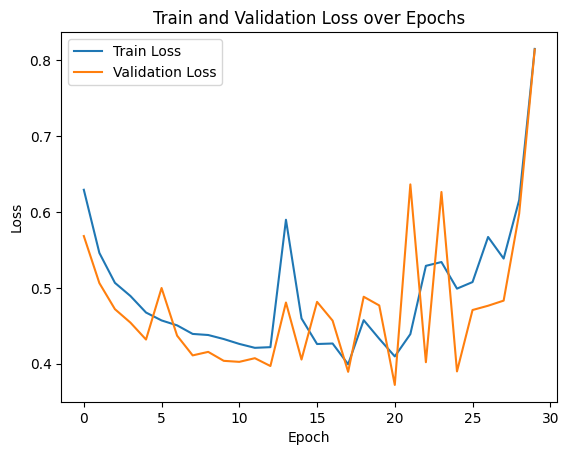

In [56]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss over Epochs")
plt.legend()
plt.show()